In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("bse30.csv"):
    bse30 = pd.read_csv("bse30.csv", index_col=0)
else:
    bse30 = yf.Ticker("^BSESN")
    bse30 = bse30.history(period="max")
    bse30.to_csv("bse30.csv")

In [3]:
from google.colab import files
files.download('bse30.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
bse30.index = pd.to_datetime(bse30.index)

In [5]:
bse30

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-07-01 00:00:00+05:30,4263.109863,4301.770020,4247.660156,4300.859863,0,0.0,0.0
1997-07-02 00:00:00+05:30,4302.959961,4395.310059,4295.399902,4333.899902,0,0.0,0.0
1997-07-03 00:00:00+05:30,4335.790039,4393.290039,4299.970215,4323.459961,0,0.0,0.0
1997-07-04 00:00:00+05:30,4332.700195,4347.589844,4300.580078,4323.819824,0,0.0,0.0
1997-07-07 00:00:00+05:30,4326.810059,4391.009766,4289.490234,4291.450195,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-13 00:00:00+05:30,80427.812500,81238.679688,80354.593750,81118.601562,6600,0.0,0.0
2025-06-16 00:00:00+05:30,81034.453125,81865.820312,81012.312500,81796.148438,11400,0.0,0.0
2025-06-17 00:00:00+05:30,81869.468750,81890.148438,81427.007812,81583.296875,21500,0.0,0.0


<Axes: xlabel='Date'>

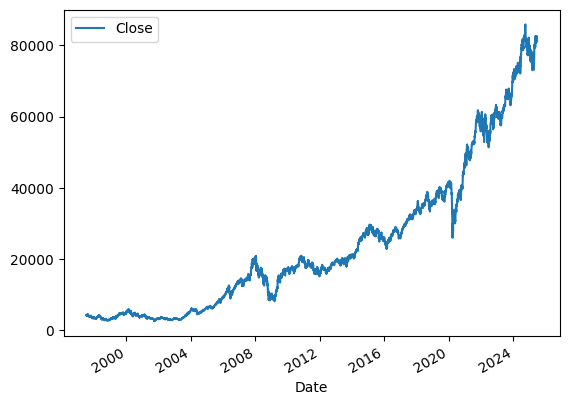

In [6]:
bse30.plot.line(y="Close", use_index=True)

In [7]:
del bse30['Stock Splits']
del bse30['Dividends']

In [8]:
bse30["Tomorrow"] = bse30["Close"].shift(-1)

In [9]:
bse30["Target"] = (bse30["Tomorrow"] > bse30["Close"]).astype(int)

In [10]:
# if you want to decrease the size of the dataset, use this line:
# bse30 = bse30.loc["2000-01-01":].copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = bse30.iloc[:-100]
test = bse30.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [12]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4909090909090909

<Axes: xlabel='Date'>

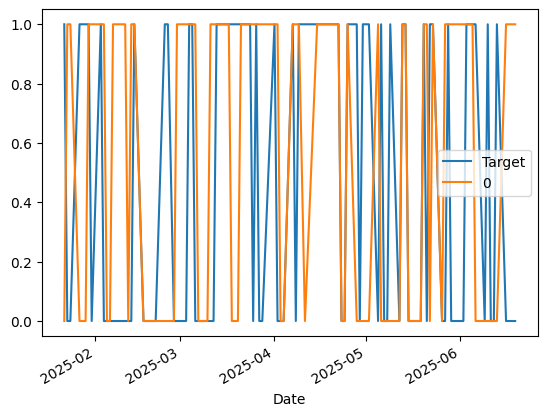

In [13]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [15]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [16]:
predictions = backtest(bse30, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,2731
1,1658


In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5223160434258143

In [19]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.526999
0,0.473001


In [20]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = bse30.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    bse30[ratio_column] = bse30["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    bse30[trend_column] = bse30.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [21]:
bse30 = bse30.dropna(subset=bse30.columns[bse30.columns != "Tomorrow"])

In [22]:
bse30

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2001-07-20 00:00:00+05:30,3375.820068,3389.489990,3331.419922,3340.750000,0,3330.979980,0,0.995503,0.0,0.984784,0.0,0.958136,27.0,0.852056,130.0,0.837352,512.0
2001-07-23 00:00:00+05:30,3340.889893,3340.889893,3310.949951,3330.979980,0,3335.080078,1,0.998536,0.0,0.987952,0.0,0.955753,27.0,0.850547,130.0,0.835113,511.0
2001-07-24 00:00:00+05:30,3326.840088,3340.909912,3306.169922,3335.080078,0,3301.969971,0,1.000615,1.0,0.994884,1.0,0.957773,27.0,0.852337,131.0,0.836348,512.0
2001-07-25 00:00:00+05:30,3307.159912,3338.219971,3296.429932,3301.969971,0,3259.030029,0,0.995011,1.0,0.989816,1.0,0.949338,26.0,0.844768,130.0,0.828258,511.0
2001-07-26 00:00:00+05:30,3298.639893,3318.600098,3254.280029,3259.030029,0,3251.530029,0,0.993455,0.0,0.983543,1.0,0.938051,26.0,0.834579,130.0,0.817698,511.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13 00:00:00+05:30,80427.812500,81238.679688,80354.593750,81118.601562,6600,81796.148438,1,0.996478,0.0,0.988859,2.0,1.021825,34.0,1.022336,124.0,1.228036,530.0
2025-06-16 00:00:00+05:30,81034.453125,81865.820312,81012.312500,81796.148438,11400,81583.296875,0,1.004159,1.0,0.998699,2.0,1.028712,34.0,1.030598,125.0,1.237718,530.0
2025-06-17 00:00:00+05:30,81869.468750,81890.148438,81427.007812,81583.296875,21500,81444.656250,0,0.998697,1.0,0.998070,2.0,1.024686,33.0,1.027658,124.0,1.233934,529.0


In [23]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [24]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [25]:
predictions = backtest(bse30, model, new_predictors)

In [26]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,3006
1.0,383


In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.597911227154047

In [28]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.533786
0,0.466214


In [29]:
predictions

,Target,Predictions
Date,,
2011-08-25 00:00:00+05:30,0,0.0
2011-08-26 00:00:00+05:30,1,0.0
2011-08-29 00:00:00+05:30,1,1.0
2011-08-30 00:00:00+05:30,1,1.0
2011-09-02 00:00:00+05:30,0,0.0
...,...,...
2025-06-13 00:00:00+05:30,1,0.0
2025-06-16 00:00:00+05:30,0,0.0
2025-06-17 00:00:00+05:30,0,0.0
